In [1]:
import scipy as sp
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics


# Check if fit code is working correctly

In [155]:
import time

X = np.array([2, 3, 4, 5, 6, 7])
Y = np.array([0, 50, 30, 40, 50, 60])/100

model_id = 'pow3'

# fitting will be even better with minimize(method=’Newton-CG’)

def get_num_par(model_id):
    if model_id == 'last1':
        return 1
    if model_id in ['pow2','log2','exp2','lin2','ilog2']:
        return 2
    if model_id in ['pow3','exp3','vap3','expp3','expd3','logpower3']:
        return 3
    if model_id in ['mmf4','wbl4','exp4','pow4']:
        return 4

def get_fun(beta):
    num_par = get_num_par(model_id)
    fun = None

    # unpack parameters
    if num_par == 1:
        a = beta[0]
    if num_par == 2:
        a, b = beta[0], beta[1]
    if num_par == 3:
        a, b, c = beta[0], beta[1], beta[2]
    if num_par == 4:
        a, b, c, d = beta[0], beta[1], beta[2], beta[3]

    # define curve models
    if model_id == 'pow2':
        fun = lambda x: -a * x **(-b)
    if model_id == 'pow3':
        fun = lambda x: a - b * x **(-c)
    if model_id == 'log2':
        fun = lambda x: -a * np.log(x) + b
    if model_id == 'exp3':
        fun = lambda x: a * np.exp(-b*x) + c
    if model_id == 'exp2':
        fun = lambda x: a * np.exp(-b*x)
    if model_id == 'lin2':
        fun = lambda x: a * x + b
    if model_id == 'vap3':
        fun = lambda x: np.exp(a + b/x + c * np.log(x))
    if model_id == 'mmf4':
        fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
    if model_id == 'wbl4':
        fun = lambda x: (c - b * np.exp(-a*(x**d)))
    if model_id == 'exp4':
        fun = lambda x: c - np.exp(-a*(x**d) + b)
    if model_id == 'expp3':
        # fun = lambda x: a * np.exp(-b*x) + c
        fun = lambda x: c - np.exp((x-b)**a)
    if model_id == 'pow4':
        fun = lambda x: a - b*(x + d)**(-c) # has to closely match pow3
    if model_id == 'ilog2':
        fun = lambda x: b - (a/np.log(x))
    if model_id == 'expd3':
        fun = lambda x: c - (c - a)*np.exp(-b*x)
    if model_id == 'logpower3':
        fun = lambda x: a / (1 + (x / np.exp(b))**c)
    if model_id == 'last1':
        fun = lambda x: (a + x) - x # casts the prediction to have the correct size
    return fun

def objective(beta): # objective function to minimize
    fun = get_fun(beta)
    return fun(X) - Y

def get_J(beta):
    num_par = get_num_par(model_id)
    if num_par == 2:
        a, b = beta[0], beta[1]
    if num_par == 3:
        a, b, c = beta[0], beta[1], beta[2]
    if num_par == 4:
        a, b, c, d = beta[0], beta[1], beta[2], beta[3]

    if model_id == 'pow2':
        J = np.array([-X**(-b), a*X**(-b)*np.log(X)])
    if model_id == 'pow3':
        J = np.array([np.ones_like(X), -X**(-c), b*X**(-c)*np.log(X)])
    if model_id == 'log2':
        J = np.array([-np.log(X), np.ones_like(X)])
    if model_id == 'exp3':
        J = np.array([exp(-b*X), -a*X*np.exp(-b*X), np.ones_like(X)])
    if model_id == 'exp2':
        J = np.array([exp(-b*X), -a*X*exp(-b*X)])
    if model_id == 'lin2':
        J = np.array([X, np.ones_like(X)])
    if model_id == 'vap3':
        J = np.array([np.exp(a + b/X + c*np.log(X)), np.exp(a + b/X + c*log(X))/X, np.exp(a + b/X + c*np.log(X))*np.log(X)])
    if model_id == 'mmf4':
        J = np.array([b/(b + X**d), a/(b + X**d) - (a*b + c*X**d)/(b + X**d)**2, X**d/(b + X**d), c*X**d*np.log(X)/(b + X**d) - X**d*(a*b + c*X**d)*np.log(X)/(b + X**d)**2])
    if model_id == 'wbl4':
        J = np.array([b*X**d*np.exp(-a*X**d), -np.exp(-a*X**d), np.ones_like(X), a*b*X**d*np.exp(-a*X**d)*np.log(X)])
    if model_id == 'exp4':
        J = np.array([X**d*np.exp(-a*X**d + b), -np.exp(-a*X**d + b), np.ones_like(X), a*X**d*np.exp(-a*X**d + b)*np.log(X)])
    if model_id == 'expp3':
        J = np.array([-(-b + X)**a*np.exp((-b + X)**a)*np.log(-b + X), a*(-b + X)**a*np.exp((-b + X)**a)/(-b + X), np.ones_like(X)])
    if model_id == 'pow4':
        J = np.array([np.ones_like(X), -(d + X)**(-c), b*(d + X)**(-c)*np.log(d + X), b*c*(d + X)**(-c)/(d + X)])
    if model_id == 'ilog2':
        J = np.array([-1/log(X), np.ones_like(X)])
    if model_id == 'expd3':
        J = np.array([np.exp(-b*X), -X*(a - c)*np.exp(-b*X), np.ones_like(X) - np.exp(-b*X)])
    if model_id == 'logpower3':
        J = np.array([((X*np.exp(-b))**c + np.ones_like(X))**(-1.0), a*c*(X*np.exp(-b))**c/((X*np.exp(-b))**c + np.ones_like(X))**2, -a*(X*np.exp(-b))**c*np.log(X*np.exp(-b))/((X*np.exp(-b))**c + np.ones_like(X))**2])
    return J.T

init = np.ones(num_par)

start = time.time()
sol = sp.optimize.least_squares(to_opt, init, method="lm",verbose=2)
end = time.time()
t1 = end-start
print('func evals',sol.nfev,t1)

start = time.time()
solJ = sp.optimize.least_squares(to_opt, init, method="lm", jac=get_J, verbose=2)
end = time.time()
t2 = end-start
print('func evals',solJ.nfev,t2)

print(t2-t1)

`ftol` termination condition is satisfied.
Function evaluations 81, initial cost 7.2794e+02, final cost 4.0750e-02, first-order optimality 1.52e-06.
func evals 81 0.0019948482513427734
`xtol` termination condition is satisfied.
Function evaluations 28, initial cost 7.2794e+02, final cost 5.5489e-01, first-order optimality 1.63e+02.
func evals 28 0.0010106563568115234
-0.00098419189453125


In [146]:
init

array([1., 1., 1.])

In [148]:
fun(init)

242.646122763888

In [156]:
fun = lambda beta: np.mean(to_opt(beta)**2)
start = time.time()
sp.optimize.minimize(fun, init, method='Newton-CG', jac=get_J) 
end = time.time()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

<function __main__.get_J.<locals>.<lambda>(a, b, c)>

In [ ]:

model_func = lambda x: np.exp(a + b/x + c * np.log(x))
X_plot = np.arange(0,10,0.01)
Y_hat = model_func(X_plot)
plt.figure()
plt.plot(X,Y,'*')
plt.plot(X_plot,Y_hat)

# Proper fitting

**************************************************
pow4


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in power


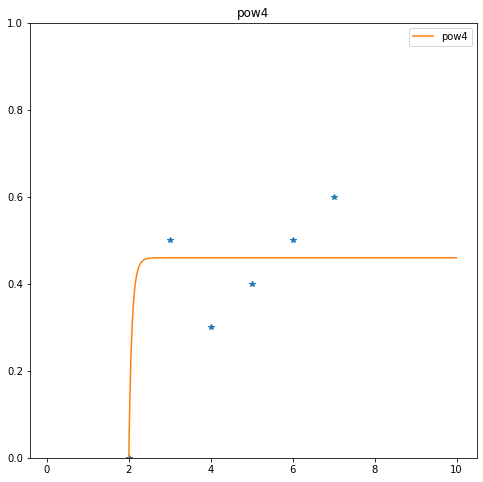

**************************************************
pow3


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in power


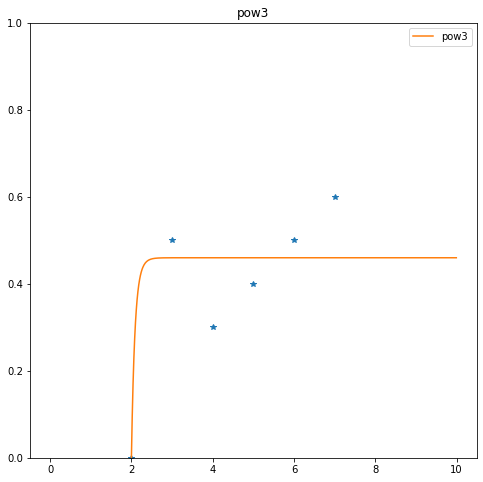

**************************************************
pow2


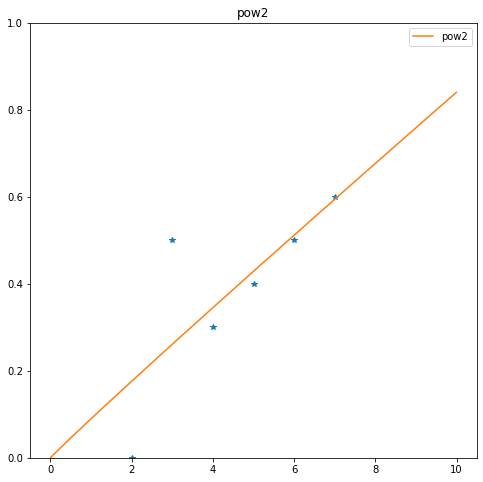

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


**************************************************
log2


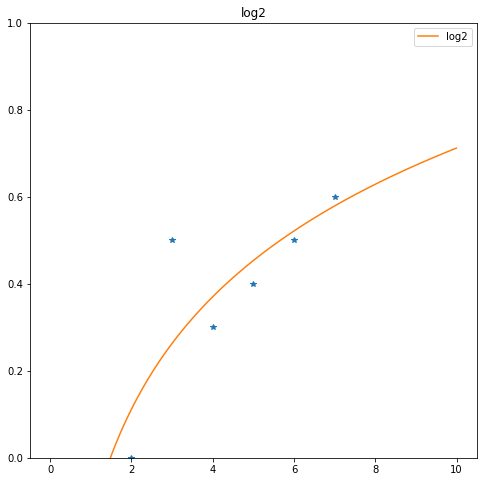

**************************************************
exp2


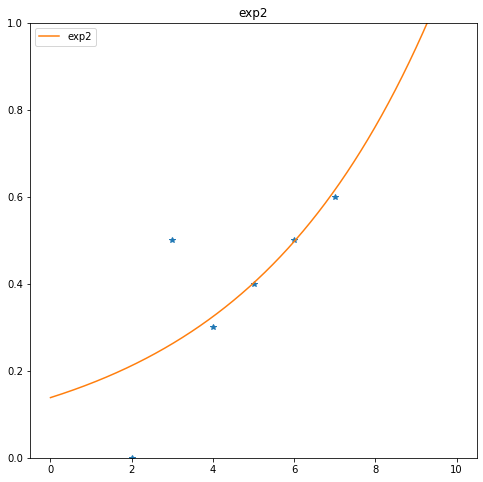

**************************************************
exp3


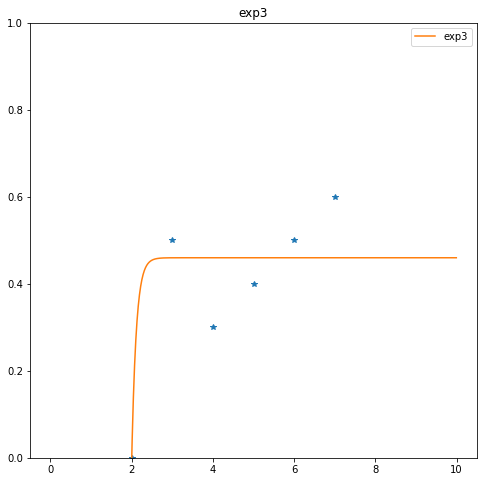

**************************************************
lin2


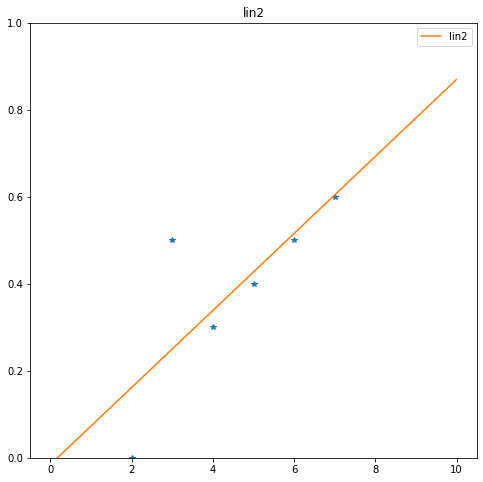

**************************************************
last1


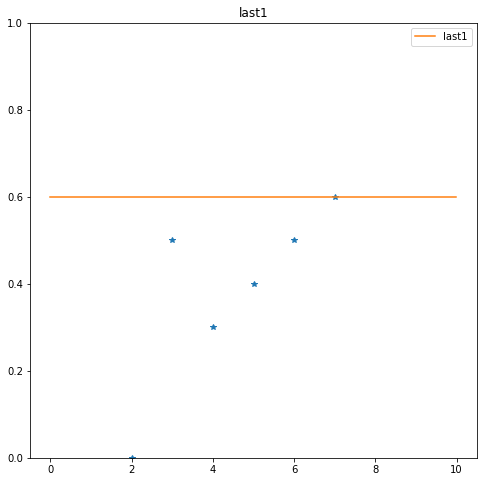

**************************************************
vap3


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in add


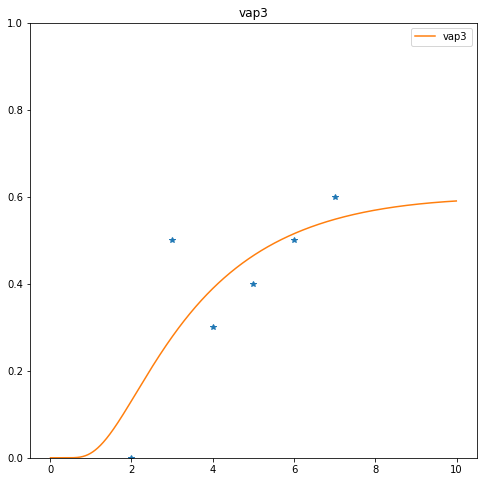

**************************************************
mmf4


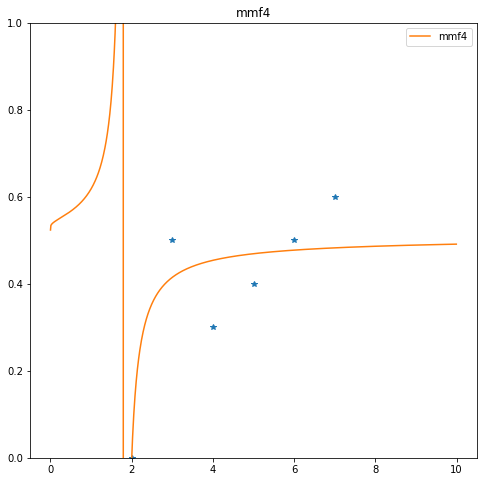

**************************************************
wbl4


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


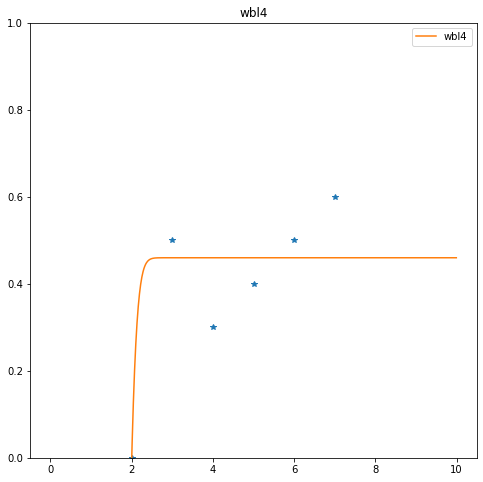

**************************************************
exp4


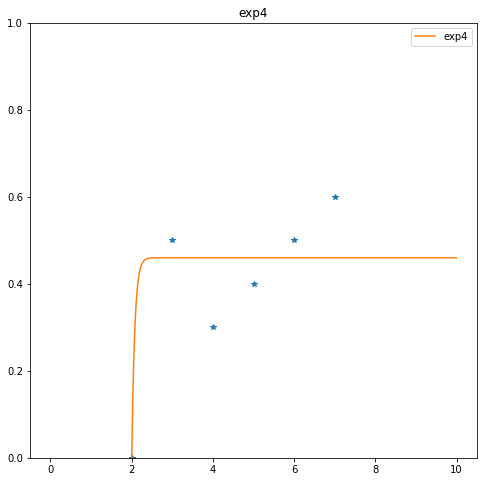

**************************************************
expp3


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in power


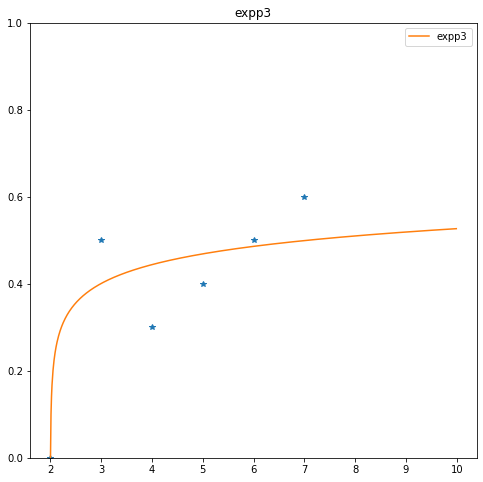

**************************************************
ilog2


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in true_divide


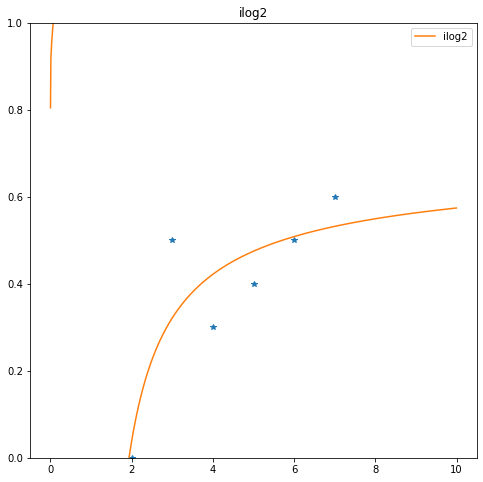

**************************************************
expd3


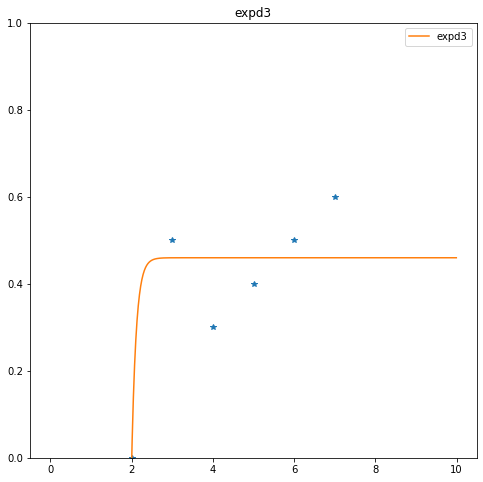

**************************************************
logpower3


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: divide by zero encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in power


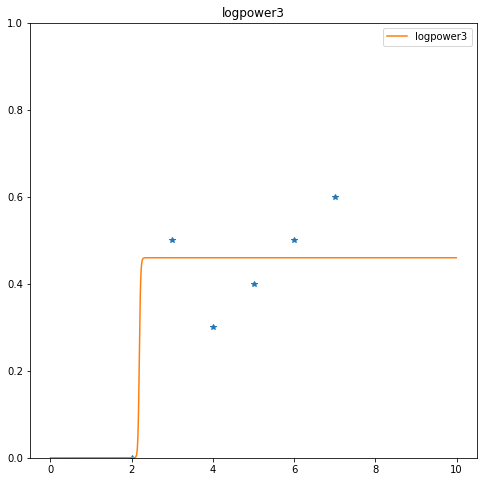

done


In [142]:
rep0 = 5       
def get_num_par(model_id):
    if model_id == 'last1':
        return 1
    if model_id in ['pow2','log2','exp2','lin2','ilog2']:
        return 2
    if model_id in ['pow3','exp3','vap3','expp3','expd3','logpower3']:
        return 3
    if model_id in ['mmf4','wbl4','exp4','pow4']:
        return 4

def fit_model(sizes, scores, sizes_extrapolation, model_id, use_jac=False):
    #print(sizes)
    #print(scores)
    #print(sizes_extrapolation)
    #print(model_id)
    
    def get_J(beta):
        num_par = get_num_par(model_id)
        if num_par == 2:
            a, b = beta[0], beta[1]
        if num_par == 3:
            a, b, c = beta[0], beta[1], beta[2]
        if num_par == 4:
            a, b, c, d = beta[0], beta[1], beta[2], beta[3]
        X = sizes

        if model_id == 'pow2':
            J = np.array([-X**(-b), a*X**(-b)*np.log(X)])
        if model_id == 'pow3':
            J = np.array([np.ones_like(X), -X**(-c), b*X**(-c)*np.log(X)])
        if model_id == 'log2':
            J = np.array([-np.log(X), np.ones_like(X)])
        if model_id == 'exp3':
            J = np.array([np.exp(-b*X), -a*X*np.exp(-b*X), np.ones_like(X)])
        if model_id == 'exp2':
            J = np.array([np.exp(-b*X), -a*X*np.exp(-b*X)])
        if model_id == 'lin2':
            J = np.array([X, np.ones_like(X)])
        if model_id == 'vap3':
            J = np.array([np.exp(a + b/X + c*np.log(X)), np.exp(a + b/X + c*np.log(X))/X, np.exp(a + b/X + c*np.log(X))*np.log(X)])
        if model_id == 'mmf4':
            J = np.array([b/(b + X**d), a/(b + X**d) - (a*b + c*X**d)/(b + X**d)**2, X**d/(b + X**d), c*X**d*np.log(X)/(b + X**d) - X**d*(a*b + c*X**d)*np.log(X)/(b + X**d)**2])
        if model_id == 'wbl4':
            J = np.array([b*X**d*np.exp(-a*X**d), -np.exp(-a*X**d), np.ones_like(X), a*b*X**d*np.exp(-a*X**d)*np.log(X)])
        if model_id == 'exp4':
            J = np.array([X**d*np.exp(-a*X**d + b), -np.exp(-a*X**d + b), np.ones_like(X), a*X**d*np.exp(-a*X**d + b)*np.log(X)])
        if model_id == 'expp3':
            J = np.array([-(-b + X)**a*np.exp((-b + X)**a)*np.log(-b + X), a*(-b + X)**a*np.exp((-b + X)**a)/(-b + X), np.ones_like(X)])
        if model_id == 'pow4':
            J = np.array([np.ones_like(X), -(d + X)**(-c), b*(d + X)**(-c)*np.log(d + X), b*c*(d + X)**(-c)/(d + X)])
        if model_id == 'ilog2':
            J = np.array([-1/np.log(X), np.ones_like(X)])
        if model_id == 'expd3':
            J = np.array([np.exp(-b*X), -X*(a - c)*np.exp(-b*X), np.ones_like(X) - np.exp(-b*X)])
        if model_id == 'logpower3':
            J = np.array([((X*np.exp(-b))**c + np.ones_like(X))**(-1.0), a*c*(X*np.exp(-b))**c/((X*np.exp(-b))**c + np.ones_like(X))**2, -a*(X*np.exp(-b))**c*np.log(X*np.exp(-b))/((X*np.exp(-b))**c + np.ones_like(X))**2])
        return J.T
    
    def get_fun(beta):
        num_par = get_num_par(model_id)
        fun = None
        
        # unpack parameters
        if num_par == 1:
            a = beta[0]
        if num_par == 2:
            a, b = beta[0], beta[1]
        if num_par == 3:
            a, b, c = beta[0], beta[1], beta[2]
        if num_par == 4:
            a, b, c, d = beta[0], beta[1], beta[2], beta[3]
        
        # define curve models
        if model_id == 'pow2':
            fun = lambda x: -a * x **(-b)
        if model_id == 'pow3':
            fun = lambda x: a - b * x **(-c)
        if model_id == 'log2':
            fun = lambda x: -a * np.log(x) + b
        if model_id == 'exp3':
            fun = lambda x: a * np.exp(-b*x) + c
        if model_id == 'exp2':
            fun = lambda x: a * np.exp(-b*x)
        if model_id == 'lin2':
            fun = lambda x: a * x + b
        if model_id == 'vap3':
            fun = lambda x: np.exp(a + b/x + c * np.log(x))
        if model_id == 'mmf4':
            fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        if model_id == 'wbl4':
            fun = lambda x: (c - b * np.exp(-a*(x**d)))
        if model_id == 'exp4':
            fun = lambda x: c - np.exp(-a*(x**d) + b)
        if model_id == 'expp3':
            # fun = lambda x: a * np.exp(-b*x) + c
            fun = lambda x: c - np.exp((x-b)**a)
        if model_id == 'pow4':
            fun = lambda x: a - b*(x + d)**(-c) # has to closely match pow3
        if model_id == 'ilog2':
            fun = lambda x: b - (a/np.log(x))
        if model_id == 'expd3':
            fun = lambda x: c - (c - a)*np.exp(-b*x)
        if model_id == 'logpower3':
            fun = lambda x: a / (1 + (x / np.exp(b))**c)
        if model_id == 'last1':
            fun = lambda x: (a + x) - x # casts the prediction to have the correct size
        return fun
    
    def objective(beta): # objective function to minimize
        fun = get_fun(beta)
        return fun(sizes) - scores
    
    # we dp multiple repititions and collect best results in lists below
    beta_list = []
    trn_error = []
    
    # this model requires no optimization
    if model_id == 'last1':
        a = scores[-1]
        return np.array([a]), get_fun(np.array([a])), 0, 0
    
    # failure statistics
    rep = rep0
    fails_fit = 0
    fails_init = 0
    i = 0
    while i <= rep: # try repeatedly
        num_par = get_num_par(model_id)
        #print('parameters %d' % num_par)
        
        beta = None
        error = True
        first = True
        # keep trying initial points until a suitable one is found
        while (error):
            
            if not first:
                fails_init += 1
                print('initial value failed, retrying for ',model_id)
            init = np.random.rand(num_par)
            
            if model_id == 'pow4': # this init works well for pow4
                best_beta, _, _, _ = fit_model(sizes, scores, sizes_extrapolation, 'pow3')
                #print(best_beta)
                init[0:3] = best_beta

            # check for errors in initial point
            trn_error_init = np.mean(objective(init)**2)
            fun_init = get_fun(init)
            sizes_all = np.hstack((sizes,sizes_extrapolation))
            hat_all = fun_init(sizes_all)
            nan_error1 = np.isnan(hat_all).any()
            inf_error1 = np.isinf(hat_all).any()
            nan_error2 = np.isnan(trn_error_init).any()
            inf_error2 = np.isinf(trn_error_init).any()
            error = nan_error1 or inf_error1 or nan_error2 or inf_error2
            
            first = False
        
        # start fitting
        # todo: fitting will be much faster if the hessian and gradient are provided analytically
        
        if use_jac:
            beta = sp.optimize.least_squares(objective, init, method="lm",jac=get_J).x
        else:
            beta = sp.optimize.least_squares(objective, init, method="lm").x
        
        # check if fit extrapolates well to unseen sizes
        fun = get_fun(beta)
        extrapolations = fun(sizes_extrapolation)
        nan_error = np.isnan(extrapolations).any()
        inf_error = np.isinf(extrapolations).any()
        
        if nan_error or inf_error:
            pass # redo's the optimization since extrapolations failed
            fails_fit += 1
            print('fit failed, nan error?',nan_error,'inf error?',inf_error,'model?',model_id)
        else:       
            i += 1
            pass # save the parameter values and objective function
            beta_list.append(beta)
            trn_error.append(np.mean(objective(beta)**2))
            
    # select the best one 
    trn_error = np.array(trn_error)
    best_i = np.argmin(trn_error)
    #print('train error')
    #print(trn_error)
    #print('best index')
    #print(best_i)
    best_beta = beta_list[best_i]
    #print(best_beta)
    return best_beta, get_fun(best_beta), fails_init, fails_fit

# pow4 doesn't fit at all
model_names = ['pow4','pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','expp3','ilog2','expd3','logpower3']

#model_names    = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','ilog2','expd3','logpower3']
#model_names    = ['exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','expp3','pow4','ilog2','expd3','logpower3']


X = np.array([2, 3, 4, 5, 6, 7])
X_extra = np.array([8, 7])
Y = np.array([0, 50, 30, 40, 50, 60])/100

import time


for model in model_names:
    print(50*'*')
    print(model)
    beta, model_func, _, _ = fit_model(X, Y, X_extra, model, use_jac=True)    
    X_plot = np.arange(0,10,0.01)
    Y_hat = model_func(X_plot)
    plt.figure(figsize=(8,8))
    plt.plot(X,Y,'*')
    plt.plot(X_plot,Y_hat,label=model)
    plt.legend()
    plt.title(model)
    plt.ylim([0,1])
    plt.show()


print('done')



In [105]:
offset = 3
sizes = [1,2,3,4,5,6,7]
sizes[:offset]
sizes[offset:]

[4, 5, 6, 7]

In [142]:
df

,openmlid,learner,size_train,size_test,outer_seed,inner_seed,score_train,score_valid,score_test
0,6,SVC_linear,16,2000,0,0,1.0000,0.1728,0.1840
1,6,SVC_linear,23,2000,0,0,1.0000,0.1939,0.1975
2,6,SVC_linear,32,2000,0,0,1.0000,0.2400,0.2385
3,6,SVC_linear,45,2000,0,0,0.9556,0.2478,0.2515
4,6,SVC_linear,64,2000,0,0,0.9844,0.3150,0.3030
...,...,...,...,...,...,...,...,...,...
1006352,722,sklearn.tree.ExtraTreeClassifier,2896,1500,4,4,1.0000,0.8800,0.8913
1006353,722,sklearn.tree.ExtraTreeClassifier,4096,1500,4,4,1.0000,0.8933,0.8987
1006354,722,sklearn.tree.ExtraTreeClassifier,5793,1500,4,4,1.0000,0.9141,0.9273
1006355,722,sklearn.tree.ExtraTreeClassifier,8192,1500,4,4,1.0000,0.9059,0.8987


In [158]:
df_all = pd.read_csv("lcdb_new.csv")
len(df_all)

1765446

In [161]:

def get_num_fits(df):
    model_names = ['pow4','pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','expp3','ilog2','expd3','logpower3']
    #model_names = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','ilog2','expd3','logpower3']
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * len(model_names),smoothing=0,miniters=1)
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        numfits = 0
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            for i in range(0,len(model_names)):
                model_name = model_names[i]
                #print(model_name)
                for offset in range(4, len(sizes)):
                    beta, model, fails_init, fails_fit = fit_model(np.array(sizes[:offset]), np.array(mean_scores[:offset]), np.array(sizes[offset:]), model_name)
                    predictions = np.round(model(sizes), 4)
                    assert(len(predictions) == len(sizes))
                    rows.append([openmlid, learner, sizes[offset - 1], predictions, model_names[i], beta, fails_init, fails_fit])
                
            numfits += 1
        rows.append([openmlid, numfits])
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "numfits"])

a = get_num_fits(df_all)
a

  0%|          | 0/64640 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\autograd\numpy\numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscrimina

Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SV

Skipping sklearn.neighbors.KNeighborsClassifier
Skipping sklearn.neural_network.MLPClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping sklearn.linear_model.PassiveAggressiveClassifier
Skipping sklearn.linear_model.Perceptron
Skipping sklearn.linear_model.SGDClassifier
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.LinearDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping SVC_linear
Skipping SVC_poly
Skipping SVC_rbf
Skipping SVC_sigmoid
Skipping sklearn.ensemble.GradientBoostingClassifier
Skipping sklearn.linear_model.LogisticRegression
Skipping skl

,openmlid,numfits
0,3,18
1,6,19
2,11,19
3,12,19
4,13,18
...,...,...
197,40498,19
198,40664,18
199,40668,14
200,40670,18


In [165]:
pd.set_option('display.max_rows', None)

model_names = ['pow4','pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','expp3','ilog2','expd3','logpower3']

(a['numfits']*len(model_names)).sum()

54224

In [143]:
df = pd.read_csv("lcdb.csv")
df_small = df.iloc[0:10000,:]
print('computing extrapolations...')
df_extrapolations = get_multiple_extrapolations_mean_curve_robust(df_small)
df_extrapolations

computing extrapolations...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: overflow encountered in multiply
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply


initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retryi

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in power


fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: overflow encountered in square


initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initia

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:105: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in multiply


initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: overflow encountered in multiply


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value f

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in multiply


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in multiply


initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retryi

,openmlid,learner,max_anchor_seen,prediction,curve_model,beta,fails_init,fails_fit
0,6,SVC_linear,45,"[0.1687, 0.1969, 0.2265, 0.2606, 0.2993, 0.340...",pow4,"[64.40045512559685, 64.7288287657525, 0.002223...",0,0
1,6,SVC_linear,64,"[0.1691, 0.1963, 0.226, 0.2617, 0.3034, 0.3497...",pow4,"[94.68683321104136, 95.17962711773585, 0.00186...",0,0
2,6,SVC_linear,91,"[0.1689, 0.1965, 0.2263, 0.2617, 0.3028, 0.347...",pow4,"[49.85656035542071, 50.30100329424926, 0.00335...",0,0
3,6,SVC_linear,128,"[0.17, 0.1961, 0.2252, 0.2607, 0.3031, 0.3508,...",pow4,"[223.1452280066187, 223.72411854471528, 0.0008...",0,0
4,6,SVC_linear,181,"[0.169, 0.1962, 0.226, 0.2618, 0.3036, 0.35, 0...",pow4,"[44.31643090084914, 44.817398134666824, 0.0040...",0,0
...,...,...,...,...,...,...,...,...
1019,6,SVC_sigmoid,2048,"[0.0493, 0.0484, 0.0476, 0.0467, 0.0458, 0.045...",logpower3,"[60.468377395485604, -131.0396467296689, 0.053...",0,0
1020,6,SVC_sigmoid,2896,"[0.0491, 0.0482, 0.0475, 0.0466, 0.0458, 0.045...",logpower3,"[51.63811690309876, -135.68734412524705, 0.050...",0,0
1021,6,SVC_sigmoid,4096,"[0.049, 0.0481, 0.0474, 0.0466, 0.0458, 0.045,...",logpower3,"[62.371115237678026, -145.2042317704174, 0.048...",0,0
1022,6,SVC_sigmoid,5793,"[0.049, 0.0482, 0.0474, 0.0466, 0.0458, 0.045,...",logpower3,"[87.01844410011027, -150.0205838500536, 0.0489...",0,0


In [390]:
df_extrapolations

,openmlid,learner,max_anchor_seen,prediction,curve_model,beta,fails_init,fails_fit
0,6,SVC_linear,45,"[0.1685, 0.1978, 0.2256, 0.2608, 0.3072, 0.367...",pow4,"[0.16845532831820972, -0.006106429250776872, -...",0,0
1,6,SVC_linear,64,"[0.1692, 0.1967, 0.2265, 0.2619, 0.3029, 0.347...",pow4,"[3.647422525209655, 4.213064123265675, 0.05132...",0,0
2,6,SVC_linear,91,"[0.1691, 0.1967, 0.2266, 0.2619, 0.3029, 0.347...",pow4,"[5.496821705951937, 6.004309206344429, 0.03236...",0,0
3,6,SVC_linear,128,"[0.1702, 0.1959, 0.2247, 0.26, 0.3024, 0.3501,...",pow4,"[9.28456998330777, 9.949129836839793, 0.022220...",0,0
4,6,SVC_linear,181,"[0.1686, 0.1962, 0.2262, 0.2622, 0.3044, 0.350...",pow4,"[12.527871670167857, 13.051004015725082, 0.014...",0,0
...,...,...,...,...,...,...,...,...
8731,14,sklearn.neural_network.MLPClassifier,256,"[0.4265, 0.4863, 0.5379, 0.5864, 0.6305, 0.668...",logpower3,"[0.810230535368526, 2.645443857681191, -0.8294...",0,0
8732,14,sklearn.neural_network.MLPClassifier,362,"[0.4281, 0.4868, 0.5375, 0.5856, 0.6297, 0.667...",logpower3,"[0.8172482203420492, 2.65421375212979, -0.8048...",0,0
8733,14,sklearn.neural_network.MLPClassifier,512,"[0.4305, 0.4877, 0.5373, 0.5847, 0.6286, 0.666...",logpower3,"[0.8270056577934041, 2.665962098710656, -0.772...",0,0
8734,14,sklearn.neural_network.MLPClassifier,724,"[0.4318, 0.488, 0.5371, 0.5841, 0.6279, 0.6662...",logpower3,"[0.8334324032865453, 2.6767871101782736, -0.75...",0,0


In [391]:
df_extrapolations.groupby('curve_model')['fails_fit'].mean()

curve_model
exp2         0.000000
exp3         0.000000
exp4         0.000000
expd3        0.000000
expp3        1.064103
ilog2        0.000000
last1        0.000000
lin2         0.000000
log2         0.000000
logpower3    0.000000
mmf4         0.168498
pow2         0.000000
pow3         0.000000
pow4         0.000000
vap3         0.000000
wbl4         0.000000
Name: fails_fit, dtype: float64

In [134]:
plt.figure()
df_extrapolations['rep'].max()

1

<Figure size 432x288 with 0 Axes>

In [138]:

def get_multiple_extrapolations_mean_curve_robust(df):
    model_names = ['pow4','pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','expp3','ilog2','expd3','logpower3']
    #model_names = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'last1', 'vap3','mmf4','wbl4','exp4','ilog2','expd3','logpower3']
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * len(model_names),smoothing=0,miniters=1)
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            #sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
            for i in range(0,len(model_names)):
                model_name = model_names[i]
                #print(model_name)
                for offset in range(4, len(sizes)):
                    beta, model, fails_init, fails_fit = fit_model(np.array(sizes[:offset]), np.array(mean_scores[:offset]), np.array(sizes[offset:]), model_name)
                    predictions = np.round(model(sizes), 4)
                    assert(len(predictions) == len(sizes))
                    rows.append([openmlid, learner, sizes[offset - 1], predictions, model_names[i], beta, fails_init, fails_fit])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "max_anchor_seen", "prediction", "curve_model", "beta", "fails_init", "fails_fit"])

In [394]:
def get_multiple_extrapolations_mean_curve(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * len(model_names))
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            #sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
            for i in range(0,len(model_names)):
                extrapolation_fun = popular_models[i]
                #print(model_names[i])
                for offset in range(4, len(sizes)):
                    beta, model = extrapolation_fun(sizes[:offset], mean_scores[:offset])
                    predictions = np.round(model(sizes), 4)
                    assert(len(predictions) == len(sizes))
                    rows.append([openmlid, learner, sizes[offset - 1], predictions, model_names[i], beta])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "max_anchor_seen", "prediction", "curve_model", "beta"])

In [395]:

def get_anchors_and_scores_mean_curve(df):
    rows = []
    for openmlid, df_dataset in tqdm(df.groupby("openmlid")):
        for learner, df_learner in df_dataset.groupby("learner"):
            sizes = None
            scores = []
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes_seed, scores_seed = df_seeded["size_train"].values, df_seeded["score_valid"].values
                if sizes is None:
                    sizes = sizes_seed
                scores.append(scores_seed)
            scores = np.array(scores)
            if len(scores.shape) != 2:
                print(f"Skipping {learner}")
                continue
            mean_scores = np.mean(scores, axis=0)
            rows.append([openmlid, learner, sizes, mean_scores])
    return pd.DataFrame(rows, columns=["openmlid", "learner", "anchor_prediction", "score"])

In [396]:

model_names    = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'baseline_last_constant', 'vap3','mmf4','wbl4','exp4','ilog2','expd3','logpower3']
popular_models = [get_ipl, get_ipl_no_bias, get_log2, get_exp2_good_init, get_exp3_good_init, get_lin2, get_constant, get_vp,get_mmf,get_wbl4,get_exp4,get_ilog2,get_expd3,get_logpower]


#model_names    = ['pow3', 'pow2', 'log2', 'exp2', 'exp3', 'lin2', 'baseline_last_constant', 'vap3','mmf4','wbl4','exp4','expp3','pow4','ilog2','expd3','logpower3']
#popular_models = [get_ipl, get_ipl_no_bias, get_log2, get_exp2_good_init, get_exp3_good_init, get_lin2, get_constant, get_vp,get_mmf,get_wbl4,get_exp4,get_expp3,get_pow4,get_ilog2,get_expd3,get_logpower]
assert(len(model_names) == len(popular_models))

def get_multiple_extrapolations(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25 * 5)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                for i in range(0,len(model_names)):
                    extrapolation_fun = popular_models[i]
                    for offset in range(4, len(sizes)):
                        beta, model = extrapolation_fun(sizes[:offset], scores[:offset])
                        predictions = np.round(model(sizes), 4)
                        assert(len(predictions) == len(sizes))
                        rows.append([openmlid, learner, outer, inner, sizes[offset - 1], predictions, model_names[i], beta])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "max_anchor_seen", "prediction", "curve_model", "beta"])

def get_anchors_and_scores(df):
    rows = []
    pbar = tqdm(total = len(pd.unique(df["openmlid"])) * len(pd.unique(df["learner"])) * 25 * 5)
    for openmlid, df_dataset in df.groupby("openmlid"):
        for learner, df_learner in df_dataset.groupby("learner"):
            for (inner, outer), df_seeded in df_learner.groupby(["inner_seed", "outer_seed"]):
                sizes, scores = df_seeded["size_train"].values, df_seeded["score_valid"].values
                rows.append([openmlid, learner, outer, inner, sizes, scores])
                pbar.update(1)
    pbar.close()
    return pd.DataFrame(rows, columns=["openmlid", "learner", "outer_seed", "inner_seed", "anchor_prediction", "score"])


NameError: name 'get_ipl' is not defined

In [397]:



def metrics_per_row(row, score, anchor_prediction):
    
    max_anchor_seen = row.max_anchor_seen
    prediction = row.prediction
    max_anchor = np.max(anchor_prediction)
    percentage_train = np.round(max_anchor_seen/max_anchor*100)/100

    trn_ind = np.argwhere(max_anchor_seen == anchor_prediction)[0][0] # recover offset
    trn_indices = range(0,(trn_ind+1))
    tst_indices = range(trn_ind+1,len(anchor_prediction))
    n_trn = len(trn_indices)
    
    y_trn_hat = prediction[trn_indices]
    y_trn = score[trn_indices]
    y_tst_hat = prediction[tst_indices]
    y_tst = score[tst_indices]

    MSE_trn = np.mean((y_trn - y_trn_hat)**2)
    MSE_tst = np.mean((y_tst - y_tst_hat)**2)
    MSE_tst_last = (y_tst[-1] -  y_tst_hat[-1])**2
    L1_trn = np.mean((y_trn -y_trn_hat)**2)
    L1_tst = np.mean((y_tst - y_tst_hat)**2)
    L1_tst_last = (y_tst[-1] - y_tst_hat[-1])**2
    
    return [MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max_anchor_seen,percentage_train,n_trn,row.curve_model]

In [398]:
def get_info(df_info, openmlid, learner, outer_seed, inner_seed):
    q = df_info.query('openmlid==@openmlid and learner==@learner and outer_seed==@outer_seed and inner_seed == @inner_seed')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [399]:
def get_info_mean_curve(df_info, openmlid, learner):
    q = df_info.query('openmlid==@openmlid and learner==@learner')
    q = q.iloc[0,:]
    return [q.anchor_prediction, q.score]

In [400]:
def df_compute_metrics_mean_curve(df,df_info):
    pbar = tqdm(total=len(df))
    rows_metrics = []
    for i in range(0,len(df)):
        row = df.iloc[i,:]
        anchor_prediction, score = get_info_mean_curve(df_info, row.openmlid, row.learner)
        rows_metrics.append(metrics_per_row(row,score,anchor_prediction))
        pbar.update(1)
    pbar.close()
    df_metrics = pd.DataFrame(rows_metrics,columns=['MSE trn','MSE tst','MSE tst last','L1 trn','L1 tst','L1 tst last','max anchor seen','percentage','n','curve_model'])
    return df_metrics

In [ ]:
#df = pd.read_csv("lcdb.csv")
df_small = df_all
print('computing extrapolations...')
df_extrapolations = get_multiple_extrapolations_mean_curve_robust(df_small)
df_extrapolations.to_csv('extrapolations.csv')
print('computing anchors and scores...')


computing extrapolations...


  0%|          | 0/64640 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in exp
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in exp


initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in exp


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp


fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan 

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in power
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
f

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
i

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retr

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in power


fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  ex

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in double_scalars


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in power


initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  ex

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retryin

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, 

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3


C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in power


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf err

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: overflow encountered in true_divide
  J_transposed[i] = df / dx


initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
f

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True in

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  ex

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: overflow encountered in double_scalars


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit fai

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in true_divide


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan 

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True 

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3


fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan er

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan e

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error?

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial valu

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value faile

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan 

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial val

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  e

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit fa

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? ex

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial valu

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error?

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit fa

fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retryin

fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp

initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan 

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
in

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retry

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan 

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? Fal

fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initi

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying f

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit fa

initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial 

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: overflow encountered in exp
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars


fit failed, nan error? False inf error? True model? exp3
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? True inf error? False model? mmf4
fit failed, nan error? False inf error? True model? exp4
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value f

fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf 

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf 

fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
initial value failed, retrying for  expp3
initial value failed, retrying for  expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
fit failed, nan error? True inf error? False model? expp3
initial value fa

In [401]:
df_anchors_and_scores = get_anchors_and_scores_mean_curve(df_small)
#df_anchors_and_scores.to_csv('anchors_scores.csv')

  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis
Skipping sklearn.tree.DecisionTreeClassifier


# Check for bad predictions

In [402]:
rows_filtered = []
pbar = tqdm(total=len(df_extrapolations))
for i in range(0,len(df_extrapolations)):
    row = df_extrapolations.iloc[i,:]
    if not np.isnan(row.prediction).any():
        rows_filtered.append(row)
    pbar.update(1)
pbar.close()
df_extrapolations_filtered = pd.DataFrame(rows_filtered)

  0%|          | 0/8736 [00:00<?, ?it/s]

In [403]:
df_extrapolations_filtered

,openmlid,learner,max_anchor_seen,prediction,curve_model,beta,fails_init,fails_fit
0,6,SVC_linear,45,"[0.1685, 0.1978, 0.2256, 0.2608, 0.3072, 0.367...",pow4,"[0.16845532831820972, -0.006106429250776872, -...",0,0
1,6,SVC_linear,64,"[0.1692, 0.1967, 0.2265, 0.2619, 0.3029, 0.347...",pow4,"[3.647422525209655, 4.213064123265675, 0.05132...",0,0
2,6,SVC_linear,91,"[0.1691, 0.1967, 0.2266, 0.2619, 0.3029, 0.347...",pow4,"[5.496821705951937, 6.004309206344429, 0.03236...",0,0
3,6,SVC_linear,128,"[0.1702, 0.1959, 0.2247, 0.26, 0.3024, 0.3501,...",pow4,"[9.28456998330777, 9.949129836839793, 0.022220...",0,0
4,6,SVC_linear,181,"[0.1686, 0.1962, 0.2262, 0.2622, 0.3044, 0.350...",pow4,"[12.527871670167857, 13.051004015725082, 0.014...",0,0
...,...,...,...,...,...,...,...,...
8731,14,sklearn.neural_network.MLPClassifier,256,"[0.4265, 0.4863, 0.5379, 0.5864, 0.6305, 0.668...",logpower3,"[0.810230535368526, 2.645443857681191, -0.8294...",0,0
8732,14,sklearn.neural_network.MLPClassifier,362,"[0.4281, 0.4868, 0.5375, 0.5856, 0.6297, 0.667...",logpower3,"[0.8172482203420492, 2.65421375212979, -0.8048...",0,0
8733,14,sklearn.neural_network.MLPClassifier,512,"[0.4305, 0.4877, 0.5373, 0.5847, 0.6286, 0.666...",logpower3,"[0.8270056577934041, 2.665962098710656, -0.772...",0,0
8734,14,sklearn.neural_network.MLPClassifier,724,"[0.4318, 0.488, 0.5371, 0.5841, 0.6279, 0.6662...",logpower3,"[0.8334324032865453, 2.6767871101782736, -0.75...",0,0


In [59]:
def get_mmf(sizes, scores):
    def mmf(beta):
        a, b, c, d = tuple(beta.astype(float))
        fun = lambda x: (a * b + c * x ** d)/(b + x ** d)
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((fun(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(mmf, np.random.randn(4), method="lm").x)
    return (a, b, c, d), lambda x: (a * b + c * x ** d)/(b + x ** d)

In [80]:

beta
#row.beta

(0.10544640365826931,
 -22.0230325738433,
 289.02195628308147,
 -2.841127819730163)

In [81]:
row.beta

(5.835647370299569, 4.797391741935361, 0.10371701844843503, 102.48989084943263)

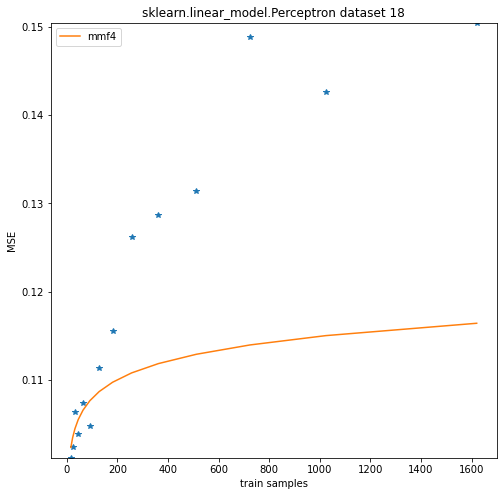

In [106]:
row_check = 0
row = rows[row_check]
learner = row.learner
openmlid = row.openmlid
n = 9
#df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
#df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

offset = np.argwhere(X == row.max_anchor_seen)[0][0]


X_trn = X[:offset+1]
Y_trn = Y[:offset+1]

get_fun = popular_models[model_names.index(row.curve_model)]

beta, predictor = get_mmf(X_trn,Y_trn)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
#for i in range(0,len(df_selected)):
#    row = df_selected.iloc[i,:]
Y_hat = predictor(X)
plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [18]:
X

array([  16,   23,   32,   45,   64,   91,  128,  181,  256,  362,  512,
        724, 1024, 1620], dtype=int64)

In [404]:
print('computing metrics....')
df_metrics = df_compute_metrics_mean_curve(df_extrapolations_filtered,df_anchors_and_scores)
#df_metrics.to_csv('metrics.csv')

computing metrics....


  0%|          | 0/8736 [00:00<?, ?it/s]

C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in square
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in double_scalars
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in square
C:\Users\tjviering\Anaconda3\envs\lcfit\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in double_scalars


In [405]:
df_metrics

,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,2.251552e-08,23.280102,218.708558,2.251552e-08,23.280102,218.708558,45,0.00,4,pow4
1,1.030218e-06,0.066640,0.268530,1.030218e-06,0.066640,0.268530,64,0.00,5,pow4
2,8.735257e-07,0.076580,0.293546,8.735257e-07,0.076580,0.293546,91,0.01,6,pow4
3,3.346322e-06,0.138434,0.484275,3.346322e-06,0.138434,0.484275,128,0.01,7,pow4
4,4.899201e-06,0.119433,0.391749,4.899201e-06,0.119433,0.391749,181,0.01,8,pow4
...,...,...,...,...,...,...,...,...,...,...
8731,1.444053e-05,0.000329,0.000700,1.444053e-05,0.000329,0.000700,256,0.16,9,logpower3
8732,1.676444e-05,0.000255,0.000465,1.676444e-05,0.000255,0.000465,362,0.22,10,logpower3
8733,1.926792e-05,0.000145,0.000230,1.926792e-05,0.000145,0.000230,512,0.32,11,logpower3
8734,2.064854e-05,0.000090,0.000120,2.064854e-05,0.000090,0.000120,724,0.45,12,logpower3


# Cleaning the data and processing

In [406]:
print('some strange values:')
print(df_metrics.isin([np.nan, np.inf, -np.inf]).sum())
df_metrics_na = df_metrics.replace([np.inf, -np.inf], np.nan)


some strange values:
MSE trn            0
MSE tst            2
MSE tst last       2
L1 trn             0
L1 tst             2
L1 tst last        2
max anchor seen    0
percentage         0
n                  0
curve_model        0
dtype: int64


In [420]:
df_extrapolations_no_curve_model = df_extrapolations.loc[:, df_extrapolations.columns != 'curve_model']
df_total = pd.concat([df_extrapolations_no_curve_model,df_metrics_na],axis=1)
df_total

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n,curve_model
0,6,SVC_linear,45,"[0.1685, 0.1978, 0.2256, 0.2608, 0.3072, 0.367...","[0.16845532831820972, -0.006106429250776872, -...",0,0,2.251552e-08,23.280102,218.708558,2.251552e-08,23.280102,218.708558,45,0.00,4,pow4
1,6,SVC_linear,64,"[0.1692, 0.1967, 0.2265, 0.2619, 0.3029, 0.347...","[3.647422525209655, 4.213064123265675, 0.05132...",0,0,1.030218e-06,0.066640,0.268530,1.030218e-06,0.066640,0.268530,64,0.00,5,pow4
2,6,SVC_linear,91,"[0.1691, 0.1967, 0.2266, 0.2619, 0.3029, 0.347...","[5.496821705951937, 6.004309206344429, 0.03236...",0,0,8.735257e-07,0.076580,0.293546,8.735257e-07,0.076580,0.293546,91,0.01,6,pow4
3,6,SVC_linear,128,"[0.1702, 0.1959, 0.2247, 0.26, 0.3024, 0.3501,...","[9.28456998330777, 9.949129836839793, 0.022220...",0,0,3.346322e-06,0.138434,0.484275,3.346322e-06,0.138434,0.484275,128,0.01,7,pow4
4,6,SVC_linear,181,"[0.1686, 0.1962, 0.2262, 0.2622, 0.3044, 0.350...","[12.527871670167857, 13.051004015725082, 0.014...",0,0,4.899201e-06,0.119433,0.391749,4.899201e-06,0.119433,0.391749,181,0.01,8,pow4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,14,sklearn.neural_network.MLPClassifier,256,"[0.4265, 0.4863, 0.5379, 0.5864, 0.6305, 0.668...","[0.810230535368526, 2.645443857681191, -0.8294...",0,0,1.444053e-05,0.000329,0.000700,1.444053e-05,0.000329,0.000700,256,0.16,9,logpower3
8732,14,sklearn.neural_network.MLPClassifier,362,"[0.4281, 0.4868, 0.5375, 0.5856, 0.6297, 0.667...","[0.8172482203420492, 2.65421375212979, -0.8048...",0,0,1.676444e-05,0.000255,0.000465,1.676444e-05,0.000255,0.000465,362,0.22,10,logpower3
8733,14,sklearn.neural_network.MLPClassifier,512,"[0.4305, 0.4877, 0.5373, 0.5847, 0.6286, 0.666...","[0.8270056577934041, 2.665962098710656, -0.772...",0,0,1.926792e-05,0.000145,0.000230,1.926792e-05,0.000145,0.000230,512,0.32,11,logpower3
8734,14,sklearn.neural_network.MLPClassifier,724,"[0.4318, 0.488, 0.5371, 0.5841, 0.6279, 0.6662...","[0.8334324032865453, 2.6767871101782736, -0.75...",0,0,2.064854e-05,0.000090,0.000120,2.064854e-05,0.000090,0.000120,724,0.45,12,logpower3


In [421]:
df_total.describe()

,openmlid,max_anchor_seen,fails_init,fails_fit,MSE trn,MSE tst,MSE tst last,L1 trn,L1 tst,L1 tst last,max anchor seen,percentage,n
count,8736.000000,8736.000000,8736.000000,8736.000000,8.736000e+03,8.734000e+03,8.734000e+03,8.736000e+03,8.734000e+03,8.734000e+03,8736.000000,8736.000000,8736.000000
mean,9.413919,1085.756410,0.142514,0.077038,8.396664e+00,6.352052e+282,1.016328e+284,8.396664e+00,6.352052e+282,1.016328e+284,1085.756410,0.171722,9.774725
std,3.838635,1886.363397,0.800942,0.487644,5.314380e+02,inf,inf,5.314380e+02,inf,inf,1886.363397,0.179393,4.374939
min,6.000000,45.000000,0.000000,0.000000,5.565938e-32,5.565938e-32,5.565938e-32,5.565938e-32,5.565938e-32,5.565938e-32,45.000000,0.000000,4.000000
25%,6.000000,91.000000,0.000000,0.000000,8.101812e-06,3.977639e-04,6.430282e-04,8.101812e-06,3.977639e-04,6.430282e-04,91.000000,0.030000,6.000000
50%,6.000000,256.000000,0.000000,0.000000,4.811910e-05,5.120378e-03,9.614195e-03,4.811910e-05,5.120378e-03,9.614195e-03,256.000000,0.090000,9.000000
75%,14.000000,1024.000000,0.000000,0.000000,1.033000e-03,5.665119e-02,1.278499e-01,1.033000e-03,5.665119e-02,1.278499e-01,1024.000000,0.280000,13.000000
max,14.000000,8192.000000,12.000000,18.000000,3.851657e+04,5.229425e+286,8.367080e+287,3.851657e+04,5.229425e+286,8.367080e+287,8192.000000,0.630000,19.000000


In [422]:
df_total.isin([np.nan, np.inf, -np.inf]).sum()

openmlid           0
learner            0
max_anchor_seen    0
prediction         0
beta               0
fails_init         0
fails_fit          0
MSE trn            0
MSE tst            2
MSE tst last       2
L1 trn             0
L1 tst             2
L1 tst last        2
max anchor seen    0
percentage         0
n                  0
curve_model        0
dtype: int64

In [423]:
df_total_clean = df_total.dropna(axis=0)
df_total_clean.isin([np.nan, np.inf, -np.inf]).sum()

openmlid           0
learner            0
max_anchor_seen    0
prediction         0
beta               0
fails_init         0
fails_fit          0
MSE trn            0
MSE tst            0
MSE tst last       0
L1 trn             0
L1 tst             0
L1 tst last        0
max anchor seen    0
percentage         0
n                  0
curve_model        0
dtype: int64

In [424]:
df_total_clean = df_total_clean.rename(columns={'MSE trn':'MSE_trn','MSE tst':'MSE_tst','MSE tst last': 'MSE_tst_last', 'L1 trn':'L1_trn', 'L1 tst':'L1_tst', 'L1 tst last':'L1_tst_last'})

In [425]:
df_total_clean.describe()

,openmlid,max_anchor_seen,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n
count,8734.000000,8734.000000,8734.000000,8734.000000,8.734000e+03,8.734000e+03,8.734000e+03,8.734000e+03,8.734000e+03,8.734000e+03,8734.000000,8734.000000,8734.000000
mean,9.414701,1085.992558,0.142546,0.077055,8.398587e+00,6.352052e+282,1.016328e+284,8.398587e+00,6.352052e+282,1.016328e+284,1085.992558,0.171761,9.775933
std,3.838727,1886.514818,0.801031,0.487698,5.314988e+02,inf,inf,5.314988e+02,inf,inf,1886.514818,0.179394,4.374705
min,6.000000,45.000000,0.000000,0.000000,5.565938e-32,5.565938e-32,5.565938e-32,5.565938e-32,5.565938e-32,5.565938e-32,45.000000,0.000000,4.000000
25%,6.000000,91.000000,0.000000,0.000000,8.096343e-06,3.977639e-04,6.430282e-04,8.096343e-06,3.977639e-04,6.430282e-04,91.000000,0.030000,6.000000
50%,6.000000,256.000000,0.000000,0.000000,4.810653e-05,5.120378e-03,9.614195e-03,4.810653e-05,5.120378e-03,9.614195e-03,256.000000,0.090000,9.000000
75%,14.000000,1024.000000,0.000000,0.000000,1.033147e-03,5.665119e-02,1.278499e-01,1.033147e-03,5.665119e-02,1.278499e-01,1024.000000,0.280000,13.000000
max,14.000000,8192.000000,12.000000,18.000000,3.851657e+04,5.229425e+286,8.367080e+287,3.851657e+04,5.229425e+286,8.367080e+287,8192.000000,0.630000,19.000000


# Distribution of MSEs

In [426]:
df_total_clean

,openmlid,learner,max_anchor_seen,prediction,beta,fails_init,fails_fit,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n,curve_model
0,6,SVC_linear,45,"[0.1685, 0.1978, 0.2256, 0.2608, 0.3072, 0.367...","[0.16845532831820972, -0.006106429250776872, -...",0,0,2.251552e-08,23.280102,218.708558,2.251552e-08,23.280102,218.708558,45,0.00,4,pow4
1,6,SVC_linear,64,"[0.1692, 0.1967, 0.2265, 0.2619, 0.3029, 0.347...","[3.647422525209655, 4.213064123265675, 0.05132...",0,0,1.030218e-06,0.066640,0.268530,1.030218e-06,0.066640,0.268530,64,0.00,5,pow4
2,6,SVC_linear,91,"[0.1691, 0.1967, 0.2266, 0.2619, 0.3029, 0.347...","[5.496821705951937, 6.004309206344429, 0.03236...",0,0,8.735257e-07,0.076580,0.293546,8.735257e-07,0.076580,0.293546,91,0.01,6,pow4
3,6,SVC_linear,128,"[0.1702, 0.1959, 0.2247, 0.26, 0.3024, 0.3501,...","[9.28456998330777, 9.949129836839793, 0.022220...",0,0,3.346322e-06,0.138434,0.484275,3.346322e-06,0.138434,0.484275,128,0.01,7,pow4
4,6,SVC_linear,181,"[0.1686, 0.1962, 0.2262, 0.2622, 0.3044, 0.350...","[12.527871670167857, 13.051004015725082, 0.014...",0,0,4.899201e-06,0.119433,0.391749,4.899201e-06,0.119433,0.391749,181,0.01,8,pow4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,14,sklearn.neural_network.MLPClassifier,256,"[0.4265, 0.4863, 0.5379, 0.5864, 0.6305, 0.668...","[0.810230535368526, 2.645443857681191, -0.8294...",0,0,1.444053e-05,0.000329,0.000700,1.444053e-05,0.000329,0.000700,256,0.16,9,logpower3
8732,14,sklearn.neural_network.MLPClassifier,362,"[0.4281, 0.4868, 0.5375, 0.5856, 0.6297, 0.667...","[0.8172482203420492, 2.65421375212979, -0.8048...",0,0,1.676444e-05,0.000255,0.000465,1.676444e-05,0.000255,0.000465,362,0.22,10,logpower3
8733,14,sklearn.neural_network.MLPClassifier,512,"[0.4305, 0.4877, 0.5373, 0.5847, 0.6286, 0.666...","[0.8270056577934041, 2.665962098710656, -0.772...",0,0,1.926792e-05,0.000145,0.000230,1.926792e-05,0.000145,0.000230,512,0.32,11,logpower3
8734,14,sklearn.neural_network.MLPClassifier,724,"[0.4318, 0.488, 0.5371, 0.5841, 0.6279, 0.6662...","[0.8334324032865453, 2.6767871101782736, -0.75...",0,0,2.064854e-05,0.000090,0.000120,2.064854e-05,0.000090,0.000120,724,0.45,12,logpower3


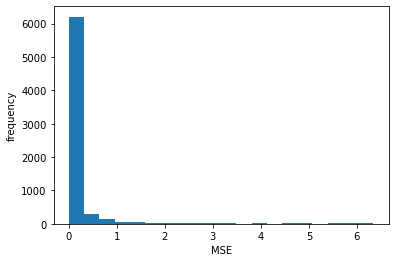

In [427]:
# MSE trn	MSE tst	MSE_tst_last	L1 trn	L1 tst	L1 tst last	max anchor seen

low, high = df_total_clean['MSE_tst_last'].quantile([0.1,0.9])
df_filtered = df_total_clean.query('{low}<MSE_tst_last<{high}'.format(low=low,high=high))
plt.hist(df_filtered['MSE_tst_last'],bins=20)
plt.xlabel('MSE')
plt.ylabel('frequency')
plt.show()


# Learning curve of a learning curve

In [428]:
num_datasets


NameError: name 'num_datasets' is not defined

In [429]:
percentage = 0.25
percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)
bucket = np.argwhere(percentage < percentage_buckets)[0][0]
bucket

3

In [430]:
#df_total_clean = df_total_clean.query('openmlid == 11')

percentage_buckets = [0.05, 0.1, 0.2, 0.4, 1]
percentage_buckets = np.array(percentage_buckets)

buckets = []

for i in range(0,len(df_total_clean)):
    row = df_total_clean.iloc[i,:]
    percentage = row.percentage
    bucket = np.argwhere(percentage < percentage_buckets)[0][0]
    buckets.append(bucket)

df_total_clean.insert(0,'quartile',buckets)


<AxesSubplot:>

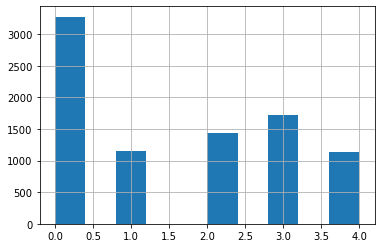

In [432]:
df_total_clean['quartile'].hist()

In [433]:
type(row)

pandas.core.series.Series

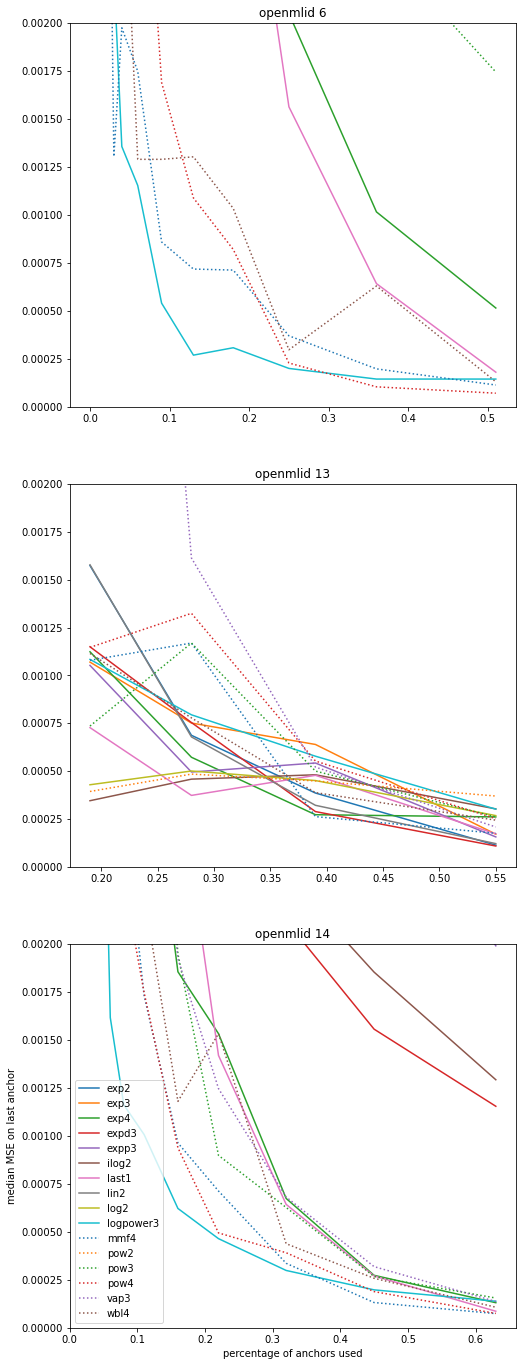

In [435]:
selected = df_total_clean
#selected = df_total_clean.query('openmlid == 11')

num_datasets = len(selected['openmlid'].unique())

fig, axs = plt.subplots(num_datasets,figsize = (8,8*num_datasets))

j = 0
for openmlid, df_dataset in selected.groupby("openmlid"):
    i = 0
    ls = '-'
    for curve_model, df_curve_model in df_dataset.groupby("curve_model"):

        Y = df_curve_model.groupby('percentage')['MSE_tst_last'].median()
        Y_sigma = df_curve_model.groupby('percentage')['MSE_tst_last'].std()
        X = df_curve_model.groupby('percentage')['MSE_tst_last'].median().index
        if i > 9:
            ls = ':'
        if num_datasets > 1:
            my_ax = axs[j]
        else:
            my_ax = axs
        my_ax.plot(X,Y,ls,label=curve_model)
        
        i += 1
    my_ax.set_ylim([0,0.002])
    my_ax.set_title('openmlid %d' % openmlid)
    j += 1
    
plt.xlabel('percentage of anchors used')
plt.ylabel('median MSE on last anchor')
plt.legend()
plt.show()


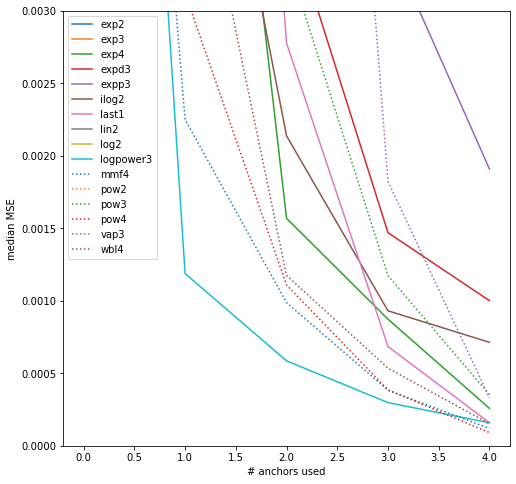

In [437]:
selected = df_total_clean

plt.figure(figsize=(8,8))

ls = '-'
i = 0
for curve_model, df_curve_model in selected.groupby("curve_model"):

    Y = df_curve_model.groupby('quartile')['MSE_tst_last'].median()
    Y_sigma = df_curve_model.groupby('quartile')['MSE_tst_last'].std()
    X = df_curve_model.groupby('quartile')['MSE_tst_last'].median().index

    if i > 9:
        ls = ':'
    i += 1
    plt.plot(X,Y,ls,label=curve_model)
    
plt.xlabel('# anchors used')
plt.ylabel('median MSE')
plt.legend()
plt.ylim([0,0.003])
plt.show()


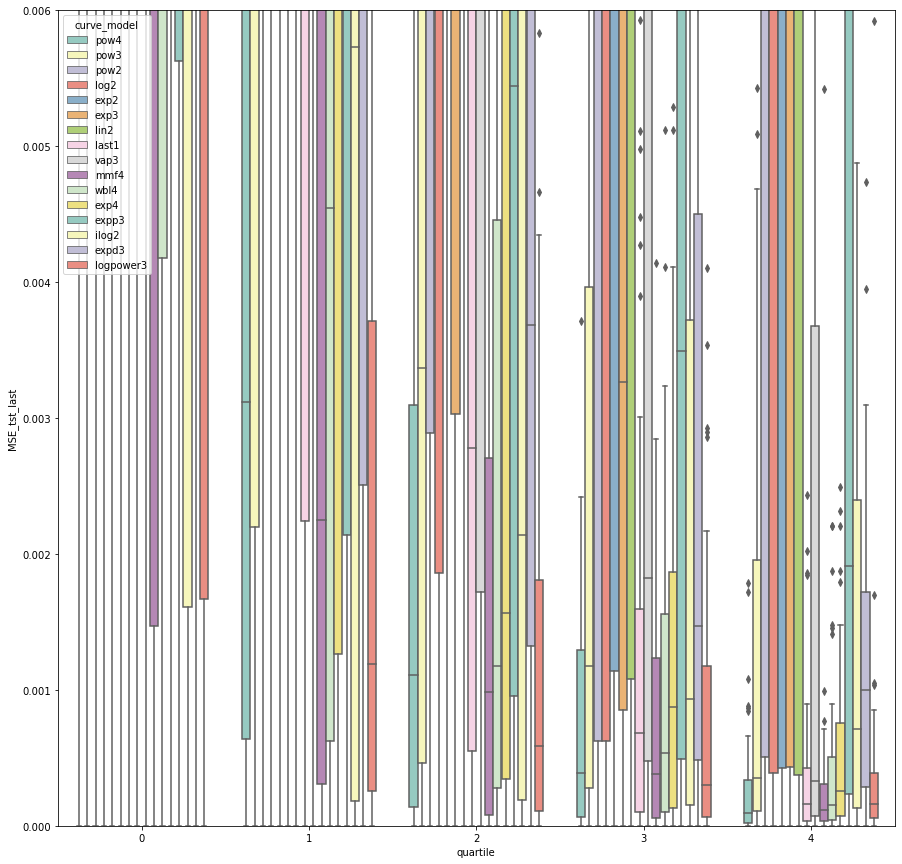

In [438]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.boxplot(x="quartile", y="MSE_tst_last", hue="curve_model", data=df_total_clean, palette="Set3") 
plt.ylim([0,0.006])
plt.show()

In [444]:
percentage_buckets_str = ['curve_model']
for perc in percentage_buckets:
    percentage_buckets_str.append(str(perc))
percentage_buckets_str = percentage_buckets_str

In [440]:
row

openmlid                                                          14
learner                         sklearn.neural_network.MLPClassifier
max_anchor_seen                                                 1024
prediction         [0.4324, 0.4882, 0.5369, 0.5838, 0.6275, 0.665...
beta               [0.8374740502928034, 2.6844408301238287, -0.74...
fails_init                                                         0
fails_fit                                                          0
MSE_trn                                                     0.000021
MSE_tst                                                      0.00007
MSE_tst_last                                                 0.00007
L1_trn                                                      0.000021
L1_tst                                                       0.00007
L1_tst_last                                                  0.00007
max anchor seen                                                 1024
percentage                        

In [442]:
rows

[['exp2',
  3.093970645127115e+47,
  112199318.94907059,
  1023.4701604627179,
  2.69352026620704,
  0.2778150130585612],
 ['exp3',
  0.0964972095999994,
  0.05513894063359995,
  0.035902831745599995,
  0.003263537858559919,
  0.023436670572159785],
 ['exp4',
  0.03486435839999987,
  0.0076654221823997445,
  0.0015689889721599432,
  0.0008736141087999634,
  0.00025846349824000005],
 ['expd3',
  0.033478167276159994,
  0.007809786179839831,
  0.0036879845151999244,
  0.0014700171756799453,
  0.0010012414777599132],
 ['expp3',
  0.019425892378240085,
  0.008791719429759964,
  0.005443784968000076,
  0.003490227545920011,
  0.00190948024576001],
 ['ilog2',
  0.01401420321856002,
  0.005730019249280095,
  0.002138595361600001,
  0.0009311920489600263,
  0.0007140011526400231],
 ['last1',
  0.0576203537977593,
  0.012345814945600012,
  0.002778311397439872,
  0.0006848903379199903,
  0.00015922401855997272],
 ['lin2',
  344.60124523059454,
  23.89750747954336,
  5.29673981334016,
  0.556109

In [443]:
percentage_buckets_str

['curve_model', '0.05', '0.1', '0.2', '0.4']

In [445]:
rows = []
for curve_model, df_subgroup in df_total_clean.groupby(["curve_model"]):
    row = [curve_model]
    for quartile, df_subgroup2 in df_subgroup.groupby(['quartile']):
        row.append(df_subgroup2['MSE_tst_last'].median())
    rows.append(row)
    
my_res = pd.DataFrame(rows,columns=[percentage_buckets_str])



In [277]:
my_res

,curve_model,0.05,0.1,0.2,0.4
0,baseline_last_constant,0.002571,0.000746,0.000177,0.000023
1,exp2,2.106864,0.533818,0.064922,0.014405
2,exp3,0.001707,0.001019,0.000272,0.000100
3,exp4,0.002207,0.000292,0.000093,0.000092
4,expd3,0.001707,0.001019,0.000272,0.000066
5,ilog2,0.001003,0.000553,0.000540,0.000308
6,lin2,0.563899,0.237786,0.043001,0.012594
7,log2,0.006516,0.003825,0.001859,0.001050
8,logpower3,0.001947,0.000220,0.000089,0.000095
9,mmf4,0.002401,0.000268,0.000102,0.000098


In [448]:
my_res_ranks = my_res.copy()
for col in percentage_buckets_str:
    if col == 'curve_model':
        continue
    my_res_ranks[col] = my_res_ranks[col].rank(method='average')
my_res_ranks['0.05']

,0.05
0,16.0
1,11.0
2,7.0
3,6.0
4,4.0
5,3.0
6,9.0
7,15.0
8,10.0
9,2.0


In [450]:
print('\\begin{table}[]')
print('\\ttfamily')
print('\\begin{tabular}{lllll}')
for (i,text) in enumerate(percentage_buckets_str):
    if text == 'curve_model':
        text = 'curve model'
    if i == 0:
        print('%12s' % text,' ',end='')
    else:
        print('%8s' % text,' ',end='')
    if i < 4:
        print('&',end='')
print('\\\\')
first = True
for i in range(0,len(my_res)):
    row = my_res.iloc[i,:]
    for (j,num) in enumerate(row.values):
        if j == 0:
            if num == 'baseline_last_constant':
                num = 'last1'
            print('%12s' % num,' ',end='')
        else:
            rank = my_res_ranks.iloc[i,j]
            if rank >= 1 and rank <= 3.5: # [1,2,3]:
                print('\\cellcolor{YellowGreen}{%8.5f} '%num,end='')
            elif rank > 3.5 and rank <= 7.5: # in [4, 5, 6, 7]:
                print('\\cellcolor{Goldenrod}{%8.5f} '%num,end='')
            elif rank > 7.5 and rank <= 10.5: #rank in [8, 9, 10]:
                print('\\cellcolor{White}{%8.5f} '%num,end='')
            elif rank > 10.5 and rank <= 14: # rank in [12,13,14]:
                print('\\cellcolor{Gray}{%8.5f} '%num,end='')
            else:
                print('\\cellcolor{Red}{%8.5f} '%num,end='')
                #print(' ')
                #print(rank)
                #print(' ')
        if j < 4:
            print('&',end='')
    print('\\\\')
print('\\end{tabular}')
print('\\end{table}')

\begin{table}[]
\ttfamily
\begin{tabular}{lllll}
 curve model  &    0.05  &     0.1  &     0.2  &     0.4       1.0  \\
        exp2  &\cellcolor{Red}{309397064512711492760509633908440394281177317376.00000} &\cellcolor{Red}{112199318.94907} &\cellcolor{Red}{1023.47016} &\cellcolor{Red}{ 2.69352} \cellcolor{Red}{ 0.27782} \\
        exp3  &\cellcolor{Gray}{ 0.09650} &\cellcolor{Gray}{ 0.05514} &\cellcolor{Gray}{ 0.03590} &\cellcolor{Gray}{ 0.00326} \cellcolor{Gray}{ 0.02344} \\
        exp4  &\cellcolor{Goldenrod}{ 0.03486} &\cellcolor{Goldenrod}{ 0.00767} &\cellcolor{Goldenrod}{ 0.00157} &\cellcolor{Goldenrod}{ 0.00087} \cellcolor{Goldenrod}{ 0.00026} \\
       expd3  &\cellcolor{Goldenrod}{ 0.03348} &\cellcolor{Goldenrod}{ 0.00781} &\cellcolor{White}{ 0.00369} &\cellcolor{White}{ 0.00147} \cellcolor{White}{ 0.00100} \\
       expp3  &\cellcolor{Goldenrod}{ 0.01943} &\cellcolor{White}{ 0.00879} &\cellcolor{White}{ 0.00544} &\cellcolor{Gray}{ 0.00349} \cellcolor{Gray}{ 0.00191} \\
     

In [140]:
a = df_total_clean.groupby('curve_model')['MSE_tst_last'].median()
a.sort_values()

curve_model
mmf4                      0.000463
exp4                      0.000641
pow3                      0.000644
wbl4                      0.000648
logpower3                 0.000789
baseline_last_constant    0.000808
ilog2                     0.001005
expd3                     0.001393
exp3                      0.001607
vap3                      0.002472
log2                      0.005279
pow2                      0.008287
lin2                      0.830964
exp2                      1.910344
Name: MSE_tst_last, dtype: float64

In [ ]:
df_total_clean['learner']

In [141]:
df_total_clean.groupby('learner')['MSE_tst_last'].median().sort_values()

learner
sklearn.naive_bayes.BernoulliNB                                0.000481
sklearn.naive_bayes.MultinomialNB                              0.001034
sklearn.linear_model.PassiveAggressiveClassifier               0.001165
sklearn.linear_model.LogisticRegression                        0.001505
sklearn.linear_model.RidgeClassifier                           0.001832
SVC_linear                                                     0.001901
sklearn.linear_model.Perceptron                                0.002013
sklearn.neighbors.KNeighborsClassifier                         0.002167
sklearn.ensemble.ExtraTreesClassifier                          0.002269
SVC_poly                                                       0.002276
sklearn.ensemble.RandomForestClassifier                        0.002468
sklearn.linear_model.SGDClassifier                             0.002546
sklearn.tree.ExtraTreeClassifier                               0.003008
sklearn.tree.DecisionTreeClassifier                     

In [142]:
df_total_clean.describe()

,openmlid,max_anchor_seen,MSE_trn,MSE_tst,MSE_tst_last,L1_trn,L1_tst,L1_tst_last,max anchor seen,percentage,n
count,300941.000000,300941.000000,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,3.009410e+05,300941.000000,300941.000000,300941.000000
mean,479.126450,4340.345058,2.183232e-03,3.582782e+298,7.059158e+299,2.183232e-03,3.582782e+298,7.059158e+299,4411.454162,0.189146,10.548274
std,326.871231,26338.706457,1.860452e-02,inf,inf,1.860452e-02,inf,inf,26800.220741,0.216448,5.080746
min,3.000000,45.000000,2.311116e-33,0.000000e+00,0.000000e+00,2.311116e-33,0.000000e+00,0.000000e+00,45.000000,0.000000,4.000000
25%,180.000000,128.000000,1.884452e-05,1.761525e-04,2.003923e-04,1.884452e-05,1.761525e-04,2.003923e-04,128.000000,0.030000,7.000000
50%,399.000000,362.000000,7.439272e-05,1.360323e-03,2.273001e-03,7.439272e-05,1.360323e-03,2.273001e-03,362.000000,0.100000,10.000000
75%,807.000000,1024.000000,3.732162e-04,1.223753e-02,2.583863e-02,3.732162e-04,1.223753e-02,2.583863e-02,1024.000000,0.300000,13.000000
max,910.000000,524288.000000,7.623948e-01,4.578164e+303,8.240695e+304,7.623948e-01,4.578164e+303,8.240695e+304,524288.000000,0.990000,31.000000


# Look at parameter values

In [ ]:
df_total_clean = df_total_clean.rename(columns={'MSE trn': 'MSE_trn'})

In [ ]:
num_curve_models = df_total_clean['curve_model'].unique()
num_curve_models

In [ ]:
plt.figure()
j = 0
df_selected = df_total_clean.query('curve_model == "lin2"')
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)

    a = np.array(beta_list)
    plt.boxplot(a)
    plt.ylim([-0.25,0.25])


In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

fig, axs = plt.subplots(len(num_curve_models),figsize=(15,15))
j = 0
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)

    a = np.array(beta_list)
    axs[j].boxplot(a)
    axs[j].set_ylim([-2,2])
    axs[j].set_title(curve_model)
    j = j+1

In [ ]:
np.array(beta_list).shape

In [ ]:
total_list = np.empty((1,1))
total_list.shape

In [ ]:
df_total_clean

#df_selected = df_total_clean.query('curve_model == "lin2" and MSE_trn < 0.05')
#df_selected = df_total_clean.query('curve_model == "lin2"')
df_selected = df_total_clean

first = True
for curve_model, df_dataset in df_selected.groupby("curve_model"):
    beta_list = []
    for i in range(0,len(df_dataset)):
        row = df_dataset.iloc[i,:]
        beta = row.beta
        beta_list.append(beta)
    beta_list = np.array(beta_list)
    if first:
        total_list = np.reshape(beta_list,(-1,1))
        first = False
    else:
        total_list = np.hstack((total_list,beta_list))
    

In [ ]:
pd.DataFrame(total_list).describe()

In [ ]:
total_list.shape

# Visualize fits

In [ ]:
df_total_clean

In [ ]:
df

In [ ]:
learners = df['learner'].unique()
learners

In [ ]:

learner = learners[18]
openmlid = 11
n = 9
df_selected = df_total_clean.query('openmlid==@openmlid and learner==@learner and n==@n')
df_selected

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

plt.figure(figsize=(8,8))
plt.plot(X,Y,'*')
for i in range(0,len(df_selected)):
    row = df_selected.iloc[i,:]
    Y_hat = row.prediction
    plt.plot(X,Y_hat,'-',label=row.curve_model)
    
plt.title('%s dataset %d' % (learner, openmlid))
plt.ylim([np.min(Y),np.max(Y)])
plt.xlabel('train samples')
plt.ylabel('MSE')
plt.legend()
plt.show()


In [ ]:
learner = 'sklearn.linear_model.Perceptron'

In [ ]:
#    def exp3(beta):
#        a, b, c = tuple(beta.astype(float))
#        pl = lambda x: a * np.exp(-b*x) + c

In [ ]:
def get_pow4(sizes, scores):
    def pow4(beta):
        a, b, c, d = tuple(beta.astype(float))
        pl = lambda x: c - (-a*x + b)**d
        penalty = []
        for i, size in enumerate(sizes):
            penalty.append((pl(size) - scores[i])**2)
        return np.array(penalty)

    a, b, c, d = tuple(sp.optimize.least_squares(pow4, np.array([0.0001,0.2,1,1]), method="lm").x)
    return (a, b, c, d), lambda x: c - (-a*x + b)**d

In [ ]:
[beta,func] = get_exp2_good_init(X,Y)

In [ ]:
Y_hat

In [ ]:
learner = learners[0]
openmlid = 11

[X, Y] = get_info_mean_curve(df_anchors_and_scores, openmlid, learner)

beta, pow4 = get_pow4(X,Y)

Y_hat = pow4(X)

plt.figure()
plt.plot(X,Y,'*')
plt.plot(X, Y_hat, '-o')


In [ ]:
beta

In [ ]:
beta

# Learner influence

(0.0, 0.1)

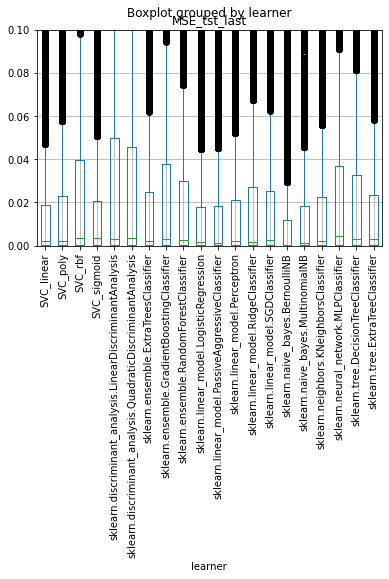

In [143]:
df_total_clean.boxplot(column='MSE_tst_last',by='learner',rot=90)
plt.ylim([0,0.1])

# Curve model influence

(0.0, 0.1)

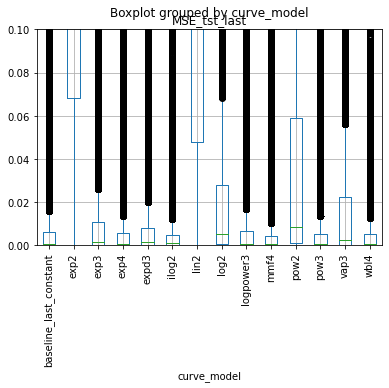

In [144]:
df_total_clean.boxplot(column='MSE_tst_last',by='curve_model',rot=90)
plt.ylim([0,0.1])

# Compute Jacobians

In [ ]:
from sympy.utilities.lambdify import lambdify

x = sym.Symbol('x')
y = sym.Symbol('y')
a = sym.Symbol('a')
b = sym.Symbol('b')
c = sym.Symbol('c')
d = sym.Symbol('d')

def get_fun_sym(model_id):
    if model_id == 'pow2':
        fun = sym.Matrix([-a * x **(-b)])
        J = np.array([-X**(-b), a*X**(-b)*np.log(X)])
    if model_id == 'pow3':
        fun = sym.Matrix([a - b * x **(-c)])
        J = np.array([np.ones_like(X), -X**(-c), b*X**(-c)*np.log(X)])
    if model_id == 'log2':
        fun = sym.Matrix([-a * sym.log(x) + b])
        J = np.array([-np.log(X), np.ones_like(X)])
    if model_id == 'exp3':
        fun = sym.Matrix([a * sym.exp(-b*x) + c])
        J = np.array([exp(-b*X), -a*X*np.exp(-b*X), np.ones_like(X)])
    if model_id == 'exp2':
        fun = sym.Matrix([a * sym.exp(-b*x)])
        J = np.array([exp(-b*X), -a*X*exp(-b*X)])
    if model_id == 'lin2':
        fun = sym.Matrix([a * x + b])
        J = np.array([X, np.ones_like(X)])
    if model_id == 'vap3':
        fun = sym.Matrix([sym.exp(a + b/x + c * sym.log(x))])
        J = np.array([np.exp(a + b/X + c*np.log(X)), np.exp(a + b/X + c*log(X))/X, np.exp(a + b/X + c*np.log(X))*np.log(X)])
    if model_id == 'mmf4':
        fun = sym.Matrix([(a * b + c * x ** d)/(b + x ** d)])
        J = np.array([b/(b + X**d), a/(b + X**d) - (a*b + c*X**d)/(b + X**d)**2, X**d/(b + X**d), c*X**d*np.log(X)/(b + X**d) - X**d*(a*b + c*X**d)*np.log(X)/(b + X**d)**2])
    if model_id == 'wbl4':
        fun = sym.Matrix([(c - b * sym.exp(-a*(x**d)))])
        J = np.array([b*X**d*np.exp(-a*X**d), -np.exp(-a*X**d), np.ones_like(X), a*b*X**d*np.exp(-a*X**d)*np.log(X)])
    if model_id == 'exp4':
        fun = sym.Matrix([c - sym.exp(-a*(x**d) + b)])
        J = np.array([X**d*np.exp(-a*X**d + b), -np.exp(-a*X**d + b), np.ones_like(X), a*X**d*np.exp(-a*X**d + b)*np.log(X)])
    if model_id == 'expp3':
        fun = sym.Matrix([c - sym.exp((x-b)**a)])
        J = np.array([-(-b + X)**a*np.exp((-b + X)**a)*np.log(-b + X), a*(-b + X)**a*np.exp((-b + X)**a)/(-b + X), np.ones_like(X)])
    if model_id == 'pow4':
        fun = sym.Matrix([a - b*(x + d)**(-c)]) # has to closely match pow3
        J = np.array([np.ones_like(X), -(d + X)**(-c), b*(d + X)**(-c)*np.log(d + X), b*c*(d + X)**(-c)/(d + X)])
    if model_id == 'ilog2':
        fun = sym.Matrix([b - (a/sym.log(x))])
        J = np.array([-1/log(X), np.ones_like(X)])
    if model_id == 'expd3':
        fun = sym.Matrix([c - (c - a)*sym.exp(-b*x)])
        J = np.array([np.exp(-b*X), -X*(a - c)*np.exp(-b*X), np.ones_like(X) - np.exp(-b*X)])
    if model_id == 'logpower3':
        fun = sym.Matrix([a / (1 + (x / sym.exp(b))**c)])
        J1 = ((X*np.exp(-b))**c + np.ones_like(X))**(-1.0)
        J2 = a*c*(X*np.exp(-b))**c/((X*np.exp(-b))**c + np.ones_like(X))**2
        J3 = -a*(X*np.exp(-b))**c*np.log(X*np.exp(-b))/((X*np.exp(-b))**c + np.ones_like(X))**2
        J = np.array([J1, J2, J3])
    return fun

model_id = 'logpower3'
fun = get_fun_sym(model_id)
num_par = get_num_par(model_id)
if num_par == 2:
    beta = sym.Matrix([a,b])
if num_par == 3:
    beta = sym.Matrix([a,b,c])
if num_par == 4:
    beta = sym.Matrix([a,b,c,d])
    
J = fun.jacobian(beta)
if num_par == 2:
    fastJ = lambdify(['a','b','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],x)
if num_par == 3:
    fastJ = lambdify(['a','b','c','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],x)
if num_par == 4:
    fastJ = lambdify(['a','b','c','d','x'],J)
    fastJ2 = lambda beta, x: fastJ(beta[0],beta[1],beta[2],beta[3],x)

inspect.getsource(fastJ)

In [ ]:
from sympy.utilities.lambdify import lambdify
inspect.getsource(fastJ)